In [1]:
import numpy as np

import matplotlib.pyplot as plt

from WDM.code.discrete_wavelet_transform.WDM import WDM_transform


# Wavelet transform (exact)

The forward discrete wavelet transform is defined

$$ w_{nm} = 2 \pi \delta t \sum_{k=0}^{N-1} g_{nm}[k] x[k] , $$

and transforms the input time-domain signal $x[k]$ ($k\in\{0,1,\ldots,N-1\}$)
into the time-frequency representation using the wavelet coefficients $w_{nm}$ 
($n\in\{0,1,\ldots,N_t-1\}$ and $m\in\{0,1,\ldots,N_f-1\}$)

The method `WDM_transform.forward_transform_exact` implements this transformation 
directly. 

WARNING: this method is slow but exact. The sum extends over the whole time-domain 
signal (i.e. no truncation in used) and time domain wavelets $g_{nm}[k]$ are computed 
using inverse FFTs. The whole thing is implemented using for loops. 

The inverse discrete wavelet transform

$$ x[k] = \sum_{n=0}^{N_t-1} \sum_{m=0}^{N_f-1} w_{nm} g_{nm}[k] , $$

is implemented in a similar way in the method `WDM_transform.inverse_transform_exact`.

In [9]:
N = 512

x = np.random.randn(N) # white noise

wdm = WDM_transform(dt=1., Nf=16, N=N, q=16)

w = wdm.forward_transform_exact(x)

x_recovered = wdm.inverse_transform_exact(w)

err = np.abs(x-x_recovered).max()

print(f"Check error is small: {err}")

Check error is small: 1.036054760872318e-06


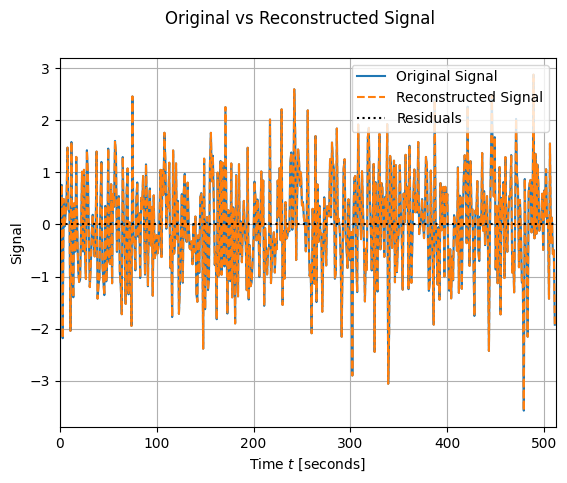

In [11]:
fig, ax = plt.subplots()

ax.plot(wdm.times, x, label='Original Signal')
ax.plot(wdm.times, x_recovered, label='Reconstructed Signal', linestyle='--')
ax.plot(wdm.times, x-x_recovered, label='Residuals', linestyle=':', c='k')
ax.set_xlim(0, wdm.T)
ax.set_xlabel('Time $t$ [seconds]')
ax.set_ylabel('Signal')
fig.suptitle('Original vs Reconstructed Signal')
ax.legend(loc='upper right')
ax.grid()
plt.show()

# Wavelet transform (truncated)

The time-domain wavelets $g_{nm}(t)$ are (approximately) localised in time. 
Therefore, it is not necessary to sum over the whole time series when computing the forward transform.
We can therefore approximate the wavelet coefficients using sums that are truncated to contain just $K=2qN_f$ terms.

The sum must be centered on the wavelets. This means we must include an offset of $n\Delta t$ in time, or $n N_f$ in 
indices in the time series. (Except for the case $m=0$ which, as we have seen must be treated separately and needs
and offset $2 n N_f$.) 

The truncated expressions for the wavelet coefficients are

$$ w_{n0} = 2 \pi \delta t \sum_{k=-K/2}^{K/2-1} g_{nm}[2 n N_f+k] x[2n N_f+k] , $$
$$ w_{nm} = 2 \pi \delta t \sum_{k=-K/2}^{K/2-1} g_{nm}[n N_f+k] x[n N_f+k] , \quad \mathrm{for}\;m>0.$$

Negative indices or indices larger then the length of the array are interpretted as wrapping around circularly; 
i.e $x[-1]=x[N-2]$ and $x[N]=x[0]$.

The parameter $q$ controls the truncation; smaller values of $q$ lead to a less accurate transforms.
The truncation parameter must be in the range $1 \leq q \leq N_t/2$ otherwise the sum contains more terms
that in the original time series.

The method `WDM_transform.forward_transform_truncated` implements this transformation 
directly. 

WARNING: this method is slow. The time domain wavelets $g_{nm}[k]$ are computed 
using inverse FFTs and the whole thing is implemented using for loops. 

In [4]:
q_vals = [1, 2, 4, 6, 8, 10, 12, 14, 16]
err_vals = np.zeros_like(q_vals, dtype=float)

for i, q in enumerate(q_vals):

    wdm = WDM_transform(dt=1., Nf=16, N=N, q=q)

    w = wdm.forward_transform_truncated(x)

    x_recovered = wdm.inverse_transform_truncated(w)

    err = float(np.max(np.abs(x-x_recovered)))

    err_vals[i] = err

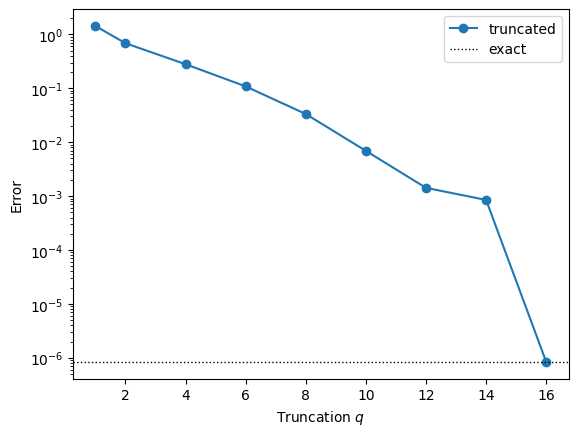

In [8]:
fig, ax = plt.subplots()
ax.plot(q_vals, err_vals, marker='o', label='truncated')
ax.axhline(err, ls=':', lw=1, c='k', label='exact')
ax.set_yscale('log')
ax.set_xlabel(r'Truncation $q$')
ax.set_ylabel(r'Error')
ax.legend(loc='upper right')
plt.show()

# Wavelet transform (truncated window)

# Demonstrate padding

In [6]:
from WDM.code.utils.utils import next_multiple

x = np.random.randn(10) # white noise

Nf = 16

# pad to next even multiple of Nf
N = next_multiple(len(x), 2*Nf) 

x_padded, mask = wdm.pad_signal(x)

wdm = WDM_transform(dt=1., Nf=Nf, N=N)

print("Original signal length:", len(x))
print("Padded signal length:", len(x_padded))

# the mask can be used to recover the original signal
assert np.allclose(x,x_padded[mask]), "oops"


Original signal length: 10
Padded signal length: 512


In [7]:
np.fft.fftfreq(20, d=1.)[19], (19-20)/20

(np.float64(-0.05), -0.05)